# TODOs

- bike deaths (NA in final trip)

In [57]:
import datetime

import h3 # uber geo package
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib

from tqdm.auto import tqdm

In [58]:
sns.set_theme()
tqdm.pandas()
matplotlib.rcParams['figure.figsize'] = (20, 10)

# load

load reference data for bike station locations

In [3]:
# TODO update
RAW = "/Users/jbishop/Downloads/cleaned_data_20220612_1302.pickle"

LOCATION_REF = "./data/stations_loc.json"

In [4]:
station_locations_df = pd.read_json(LOCATION_REF).T

main data, load with dask

In [5]:
# load raw data
df = pd.read_pickle(RAW)

about 100M rows

In [6]:
# num rows
len(df)

99448614

some cleaning of bad dates

In [7]:
EARLIEST_DATE = datetime.datetime(2010, 1, 1)

In [8]:
%%time
# filter out of range dates
df = df[df["start_date"] > EARLIEST_DATE]
# allow NA for end dates
df = df[(df["end_date"] > EARLIEST_DATE) | df["end_date"].isna()]

# also drop entries where start date before end date
df = df[df["start_date"] < df["end_date"]]

CPU times: user 38.6 s, sys: 13.4 s, total: 52 s
Wall time: 52.2 s


In [9]:
# recalc duration
df["duration"] = df["end_date"]  - df["start_date"] 

we've lost a few!

In [40]:
len(df)

98907750

# Basic stats

In [10]:
%%time
# how many bikes
df["bike_id"].nunique()

CPU times: user 6.62 s, sys: 877 ms, total: 7.49 s
Wall time: 7.48 s


21149

In [11]:
bike_groups = df.groupby("bike_id")

In [12]:
%%time
# bike with the most trips
group_counts = bike_groups.count()["filename"] # pick abritrary column (without nulls) to get counts
b_id = group_counts.idxmax()
n_trips = group_counts.loc[b_id]

print(f"""
bike with most trips: {b_id}
did {n_trips} trips
""")


bike with most trips: 8875
did 10197 trips

CPU times: user 37 s, sys: 638 ms, total: 37.7 s
Wall time: 37.6 s


In [13]:
%%time
# bike with the longest trips
group_sums = bike_groups["duration"].sum()
b_id = group_sums.idxmax()
d_sum = group_sums.loc[b_id]


print(f"""
bike with longest sum duration of trips: {b_id}
total of {d_sum} seconds
""")


bike with longest sum duration of trips: 2143
total of 234 days 19:13:00 seconds

CPU times: user 1.15 s, sys: 213 ms, total: 1.36 s
Wall time: 1.36 s


how long are trips? (excluding outliers)

<AxesSubplot:>

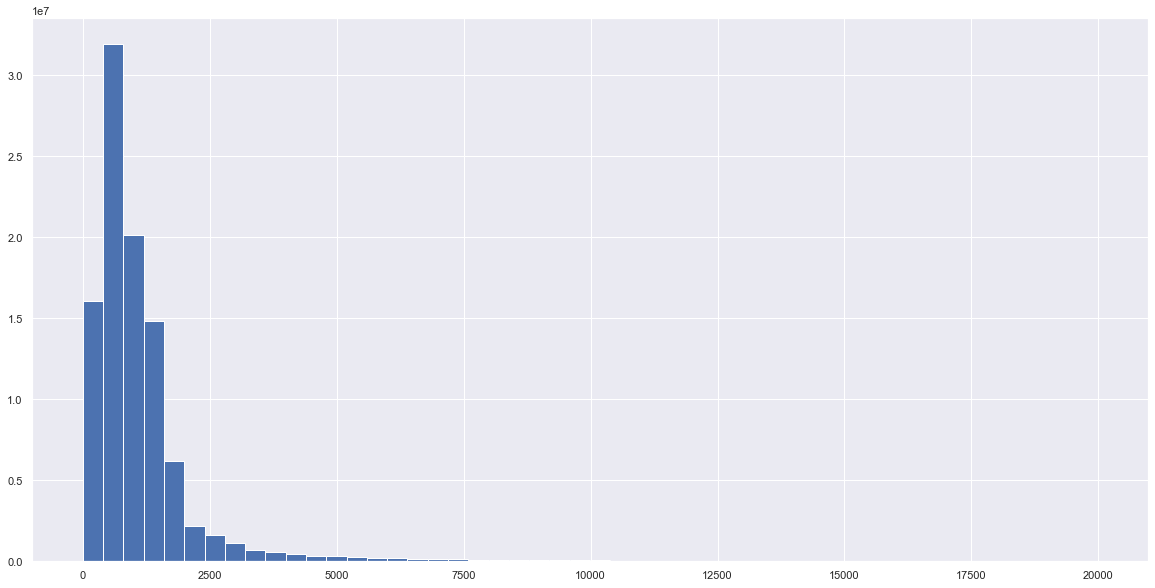

In [78]:
df[df["duration"].dt.seconds < 20000]["duration"].dt.seconds.hist(bins=50)

## Long-lived bikes

In [14]:
%%time
trips_per_bike = bike_groups["filename"].count()

CPU times: user 3.66 s, sys: 34.4 ms, total: 3.7 s
Wall time: 3.69 s


In [15]:
%%time
# relies on time ordering of df via rental_id
bike_start = bike_groups["start_date"].first()

CPU times: user 426 ms, sys: 1.76 ms, total: 428 ms
Wall time: 426 ms


In [16]:
%%time
# relies on time ordering of df via rental_id
bike_end = bike_groups["end_date"].last()

CPU times: user 787 ms, sys: 2.24 ms, total: 789 ms
Wall time: 787 ms


In [17]:
%%time 
bike_lifetime = bike_end - bike_start

CPU times: user 1.62 ms, sys: 1.19 ms, total: 2.81 ms
Wall time: 1.71 ms


<AxesSubplot:>

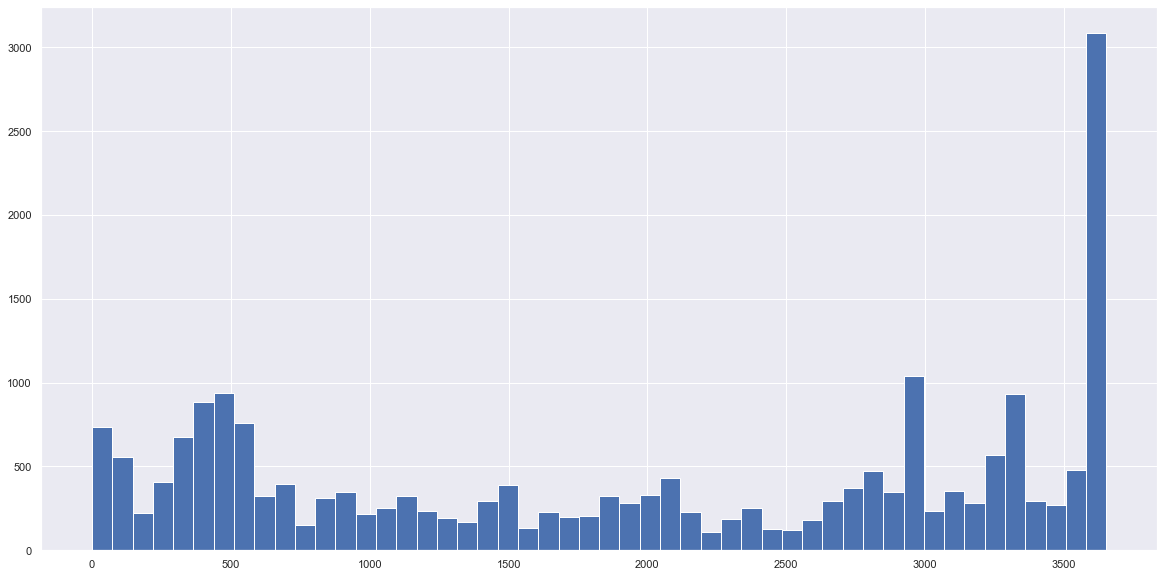

In [61]:
bike_lifetime.dt.days.hist(bins=50)

In [18]:
%%time
duration_sums = bike_groups["duration"].sum()

CPU times: user 1.03 s, sys: 200 ms, total: 1.23 s
Wall time: 1.22 s


In [19]:
%%time
bike_utilisation = duration_sums / bike_lifetime

CPU times: user 624 µs, sys: 253 µs, total: 877 µs
Wall time: 604 µs


In [20]:
bike_utilisation.mean()

0.041590354670607635

<AxesSubplot:>

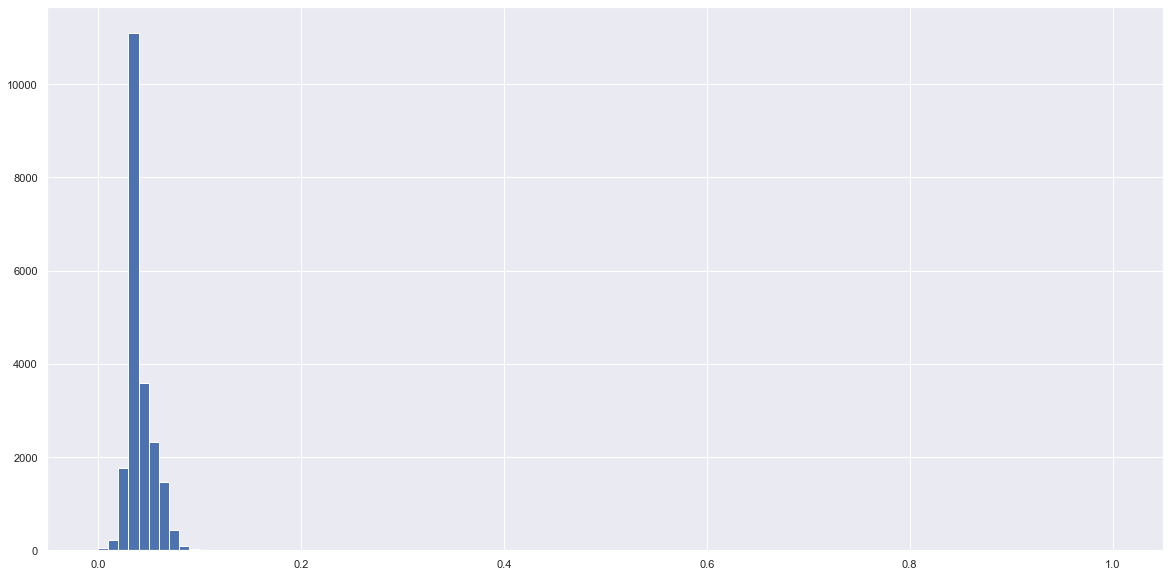

In [60]:
bike_utilisation.hist(bins=100)

### per month

- how many bikes are "alive" by month?

- how many stations are "alive" by month?

- what is bike utilisation by month?

In [22]:
# don't want to incude first and last months as may be incompelte, use in filter later
incomplete_months = df["start_date"].iloc[[0, -1]].dt.to_period("M")


# create a complete monthly index that covers ALL months in period 
complete_monthly_index = pd.date_range(start=df["start_date"].iloc[0], end=df["end_date"].iloc[-1], freq="M").to_period("M")
# remove incomplete months
complete_monthly_index = complete_monthly_index.delete(complete_monthly_index.isin(incomplete_months))

In [23]:
# TODO should stations count as allive for next month rather than current?
def calc_alive_per_month(starts: pd.Series, ends: pd.Series, incomplete_months: pd.Series, complete_monthly_index: pd.PeriodIndex):
    starts_per_month = starts.dt.to_period("M").value_counts()
    ends_per_month = ends.dt.to_period("M").value_counts()

    counts_df = complete_monthly_index.to_frame(name="foo").join(starts_per_month).join(ends_per_month).sort_index().fillna(0)
    # ending items should only be counted at the start of next month, so shift
    counts_df["end_date"] = counts_df["end_date"].shift(fill_value=0)

    alive_per_month = counts_df["start_date"].cumsum() - counts_df["end_date"].cumsum()
    
    return alive_per_month[~alive_per_month.index.isin(incomplete_months)]

In [24]:
%%time

alive_bikes_per_month = calc_alive_per_month(starts=bike_start, ends=bike_end, incomplete_months=incomplete_months, complete_monthly_index=complete_monthly_index)

CPU times: user 9.76 ms, sys: 1.37 ms, total: 11.1 ms
Wall time: 10.2 ms


In [25]:
%%time
duration_sums_per_month = df[["duration"]].groupby(df["start_date"].dt.to_period("M"))["duration"].sum()

duration_sums_per_month = duration_sums_per_month.to_frame()
duration_sums_per_month["max_possible_duration"] = duration_sums_per_month.index.map(lambda x: x.end_time - x.start_time)

utilisation_per_month = duration_sums_per_month["duration"] / duration_sums_per_month["max_possible_duration"] / alive_bikes_per_month

# remove incomplelte months
utilisation_per_month = utilisation_per_month[~utilisation_per_month.index.isin(incomplete_months)]

CPU times: user 4.83 s, sys: 1.13 s, total: 5.96 s
Wall time: 5.96 s


In [26]:
%%time

station_groups = df.groupby("start_station_id")

# relies on time ordering of df via rental_id
station_start = station_groups["start_date"].first()
station_end = station_groups["end_date"].last()

CPU times: user 5.85 s, sys: 403 ms, total: 6.25 s
Wall time: 6.23 s


In [27]:
alive_stations_per_month = calc_alive_per_month(starts=station_start, ends=station_end,
                                                incomplete_months=incomplete_months, complete_monthly_index=complete_monthly_index)

In [28]:
# forward fill gaps
stats_df = complete_monthly_index.to_frame(name="date")\
    .join(alive_bikes_per_month.rename("alive_bikes"))\
    .join(alive_stations_per_month.rename("alive_stations"))\
    .join(utilisation_per_month.rename("utilisation"))\
    .fillna(method="ffill") 

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

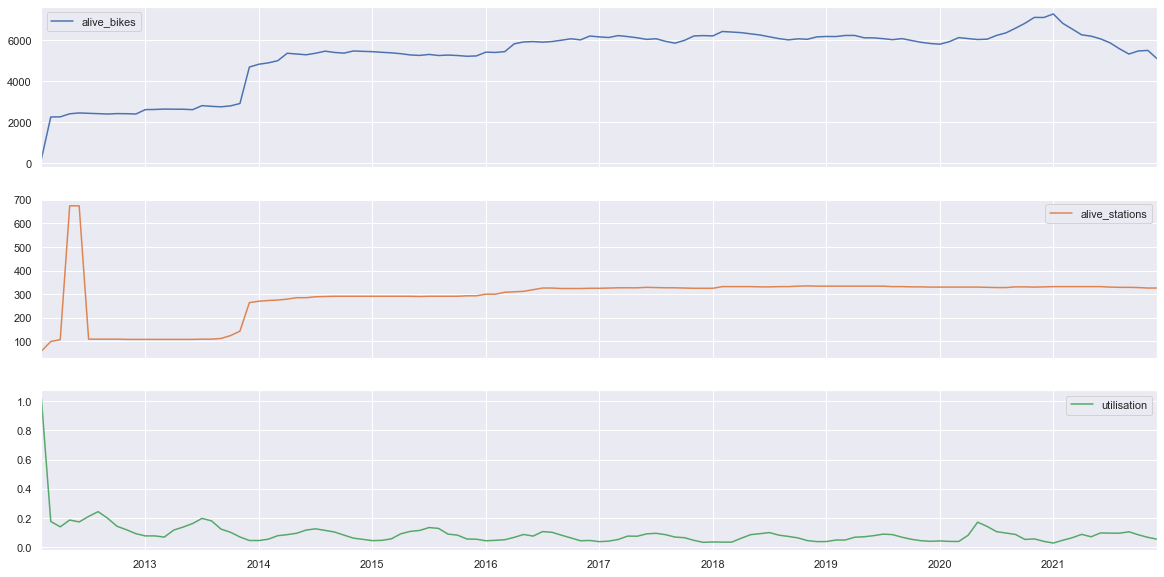

In [62]:
stats_df.plot(subplots=True)

whats happening to the number of active stations in 2012?

In [64]:
stats_df_2012 = stats_df[(stats_df.index.to_timestamp() >= datetime.datetime(year=2012, month=1, day=1)) &
        (stats_df.index.to_timestamp() < datetime.datetime(year=2013, month=1, day=1))]


# increase in April and Decrease in Jul

may_2012_new_stations = station_start[(station_start >= datetime.datetime(year=2012, month=5, day=1)) &
             (station_start < datetime.datetime(year=2012, month=6, day=1))]

# note these will actually be last used in prev month i.e. june
jul_2012_removed_stations = station_end[(station_end >= datetime.datetime(year=2012, month=6, day=1)) &
             (station_end < datetime.datetime(year=2012, month=7, day=1))]

len(may_2012_new_stations), len(jul_2012_removed_stations)

(568, 566)

## Station Areas

In [38]:
%%time
all_stations = pd.concat([
    df[["start_station_id", "start_station_name"]].rename(columns={"start_station_id": "id", "start_station_name": "name"}),
    df[["end_station_id", "end_station_name"]].rename(columns={"end_station_id": "id", "end_station_name": "name"})
]).convert_dtypes().set_index(keys="id").drop_duplicates().dropna()

CPU times: user 57.9 s, sys: 13.8 s, total: 1min 11s
Wall time: 1min 13s


have a look at station name pieces, is the part after the comma an "area"?

In [39]:
station_name_pieces = all_stations["name"].progress_map(lambda name: name.split(","))

station_single_pieces = station_name_pieces[station_name_pieces.progress_map(len) <= 1]
station_areas =  station_name_pieces.progress_map(lambda name_pieces: name_pieces[1] if len(name_pieces) > 1 else None).dropna()

  0%|          | 0/2410 [00:00<?, ?it/s]

AttributeError: 'int' object has no attribute 'split'

what are the items with only one "piece" i.e. no comma

In [ ]:
station_single_pieces.head()

In [ ]:
station_areas.value_counts()

# chains

run for some subset only. Try long lived bikes

In [ ]:
top_ten_lived_bike_ids = bike_lifetime.sort_values()[-10:].index.values

In [209]:
top_ten_bike_subset = df[df["bike_id"].isin(top_ten_lived_bike_ids)].copy()

In [210]:
# NOTE - how to handle workshops?
# what if workshop is start ?
# what if workshop is end ?
def add_chains(bike_id: int, bike_group: pd.DataFrame, df: pd.DataFrame) -> None:
    """ note: adds to dataframe as side effect """

    # note fillna for end station to allow for comparison to NA
    breaks = bike_group[bike_group["start_station_id"] != bike_group.shift()["end_station_id"].fillna(-1)]
    break_indices = breaks.index.values

    chains = list()
    for i, (start, end) in enumerate(zip([None, *break_indices], [*break_indices, None])):
        chain = bike_group.loc[start:end]
        chain_id = f"{bike_id}_{i}"
        chains.append(pd.Series(chain_id, index=chain.index))
    return pd.concat(chains)

In [211]:
chains = list()
for k, g in tqdm(top_ten_bike_subset.groupby("bike_id")):
    g = bike_groups.get_group(k)
    chains.append(add_chains(bike_id=k, bike_group=g, df=df))

  0%|          | 0/10 [00:00<?, ?it/s]

In [218]:
top_ten_bike_subset = top_ten_bike_subset.join(pd.concat(chains).rename("chain_id"))

In [219]:
top_ten_bike_subset.to_pickle("top_ten_bikes.pickle")

----

In [112]:
boris = df[df["bike_id"] == 10296]

In [121]:
#feb13
boris[(boris["start_date"].dt.month == 1) & (boris["start_date"].dt.year == 2013)]

,duration,bike_id,end_date,end_station_id,end_station_name,start_date,start_station_id,start_station_name,filename
rental_id,,,,,,,,,


In [122]:
boris.iloc

,duration,bike_id,end_date,end_station_id,end_station_name,start_date,start_station_id,start_station_name,filename
rental_id,,,,,,,,,
29502441,0 days 00:05:00,10296,2013-12-17 08:42:00,73,"Old Street Station, St. Luke's",2013-12-17 08:37:00,351.0,"Macclesfield Rd, St Lukes",../bikes/14. Journey Data Extract 08Dec13-04Ja...
29504497,0 days 00:07:00,10296,2013-12-17 09:31:00,135,"Clerkenwell Green, Clerkenwell",2013-12-17 09:24:00,73.0,"Old Street Station, St. Luke's",../bikes/14. Journey Data Extract 08Dec13-04Ja...
29504753,0 days 00:05:00,10296,2013-12-17 09:40:00,66,"Holborn Circus, Holborn",2013-12-17 09:35:00,135.0,"Clerkenwell Green, Clerkenwell",../bikes/14. Journey Data Extract 08Dec13-04Ja...
29505281,0 days 00:15:00,10296,2013-12-17 10:20:00,717,"Dunston Road , Haggerston",2013-12-17 10:05:00,593.0,"Northdown Street, King's Cross",../bikes/14. Journey Data Extract 08Dec13-04Ja...
29506025,0 days 00:05:00,10296,2013-12-17 11:18:00,553,"Regent's Row , Haggerston",2013-12-17 11:13:00,717.0,"Dunston Road , Haggerston",../bikes/14. Journey Data Extract 08Dec13-04Ja...
...,...,...,...,...,...,...,...,...,...
115953249,0 days 00:07:00,10296,2022-01-01 11:56:00,345,"Flood Street, Chelsea",2022-01-01 11:49:00,757.0,"Harcourt Terrace, West Brompton",../bikes/298JourneyDataExtract29Dec2021-04Jan2...
115966882,0 days 00:01:00,10296,2022-01-01 21:52:00,345,"Flood Street, Chelsea",2022-01-01 21:51:00,345.0,"Flood Street, Chelsea",../bikes/298JourneyDataExtract29Dec2021-04Jan2...
115967025,0 days 00:31:00,10296,2022-01-01 22:36:00,655,"Crabtree Lane, Fulham",2022-01-01 22:05:00,345.0,"Flood Street, Chelsea",../bikes/298JourneyDataExtract29Dec2021-04Jan2...
